In [1]:
import cv2
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

In [2]:
vehiculos_n_archivos = glob.glob('dataset/vehicles/**/*.png')
novehiculos_n_archivos = glob.glob('dataset/non-vehicles/**/*.png')

In [3]:
print "Cantidad de imágenes de automóviles: ", len(vehiculos_n_archivos)
print "Cantidad de imágenes de no automóviles: ", len(novehiculos_n_archivos)

Cantidad de imágenes de automóviles:  8792
Cantidad de imágenes de no automóviles:  8968


Text(0.5,1,'No vehiculo')

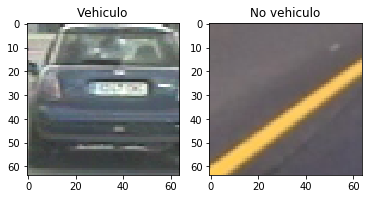

In [8]:
img_vehiculo = cv2.imread(vehiculos_n_archivos[3])
img_novehiculo = cv2.imread(novehiculos_n_archivos[6])

fig, (vehiculo_plt, novehiculo_plt) = plt.subplots(1, 2)

vehiculo_plt.imshow(cv2.cvtColor(img_vehiculo, cv2.COLOR_BGR2RGB))
vehiculo_plt.set_title('Vehiculo')

novehiculo_plt.imshow(cv2.cvtColor(img_novehiculo, cv2.COLOR_BGR2RGB))
novehiculo_plt.set_title('No vehiculo')

## Extractor de Características: HOG (Histogram Oriented Gradient)

In [9]:
carac_hog_vehiculo, img_vehiculo_hog = hog(img_vehiculo[:,:,0], orientations = 9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, visualise=True, feature_vector=True)

carac_hog_novehiculo, img_novehiculo_hog = hog(img_novehiculo[:,:,0], orientations = 9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, visualise=True, feature_vector=True)

Text(0.5,1,'No Vehiculo: HOG')

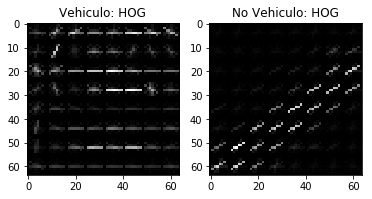

In [10]:
fig2, (hog_vehiculo_plt, hog_novehiculo_plt) = plt.subplots(1, 2)

hog_vehiculo_plt.imshow(img_vehiculo_hog, cmap='gray')
hog_vehiculo_plt.set_title('Vehiculo: HOG')

hog_novehiculo_plt.imshow(img_novehiculo_hog, cmap='gray')
hog_novehiculo_plt.set_title('No Vehiculo: HOG')

In [11]:
print "Dimensiones de la imagen: ", img_vehiculo.shape

Dimensiones de la imagen:  (64, 64, 3)


In [12]:
def obtener_vector_caracteristicas_all(imgs, orient, pix_per_cell, cell_per_block, hog_channel, color_space="RGB"):
    '''
    Funcion que retorna el vector de caracteristicas de HOG de una lista de imagenes
    '''
    caracteristicas = []
    for file_img in imgs:
        img = mpimg.imread(file_img)
        
        # Para cambiar el color_space de la imagen (si asi se lo desea) --> Agregar mas para realizar el testeo
        if color_space != "RGB":
            if color_space == 'HLS':
                carac_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'HSV':
                carac_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        else:
            carac_img = np.copy(img)
        
        # si hog_chanell es 3 (quiere decir todos los canales)
        if hog_channel == 3:
            hog_caracteristicas =[]
            for c in range(carac_img.shape[2]):
                hog_carac_img = hog(carac_img[:,:,c], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=False, feature_vector=True)
                hog_caracteristicas.append(hog_carac_img)
            hog_caracteristicas = np.ravel(hog_caracteristicas)
        else:
            hog_caracteristicas = hog(carac_img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=False, feature_vector=True)
        
        caracteristicas.append(hog_caracteristicas)
    
    return caracteristicas

In [13]:
def obtener_vector_caracteristicas_img(imagen, orient, pix_per_cell, cell_per_block, hog_channel, color_space="RGB"):
    '''
    Funcion que retorna el vector de caracteristicas de HOG de una lista de imagenes
    '''
    caracteristicas = []

    img = np.copy(imagen)

    # Para cambiar el color_space de la imagen (si asi se lo desea) --> Agregar mas para realizar el testeo
    if color_space != "RGB":
        if color_space == 'HLS':
            carac_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'HSV':
            carac_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    else:
        carac_img = np.copy(img)

    # si hog_chanell es 3 (quiere decir todos los canales)
    if hog_channel == 3:
        hog_caracteristicas =[]
        for c in range(carac_img.shape[2]):
            hog_carac_img = hog(carac_img[:,:,c], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=False, feature_vector=True)
            hog_caracteristicas.append(hog_carac_img)
        hog_caracteristicas = np.ravel(hog_caracteristicas)
    else:
        hog_caracteristicas = hog(carac_img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=False, feature_vector=True)

    caracteristicas.append(hog_caracteristicas)
    
    return caracteristicas

## Entrenamiento

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

In [15]:
hog_caracteristicas_vehiculos = obtener_vector_caracteristicas_all(vehiculos_n_archivos, 
                                                                orient=9,
                                                                pix_per_cell=8,
                                                                cell_per_block=2,
                                                                hog_channel=3,
                                                                color_space="RGB")

hog_caracteristicas_no_vehiculos = obtener_vector_caracteristicas_all(novehiculos_n_archivos, 
                                                                orient=9,
                                                                pix_per_cell=8,
                                                                cell_per_block=2,
                                                                hog_channel=3,
                                                                color_space="RGB")

### Estandarizacion de Caracteristicas

In [16]:
X = np.vstack((hog_caracteristicas_vehiculos, hog_caracteristicas_no_vehiculos)).astype(np.float64)

In [17]:
scaler_std = StandardScaler()

# Calcula la media y el desvio estándar que se utilizaran para escalar posteriormente.
X_scaler = scaler_std.fit(X)
# Realiza la estandarizacion centrando y escalando
X_scaled = X_scaler.transform(X)

In [18]:
y = np.hstack((np.ones(len(hog_caracteristicas_vehiculos)), np.zeros(len(hog_caracteristicas_no_vehiculos))))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20)

In [20]:
model_svc = svm.LinearSVC()

In [21]:
model_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
model_svc.score(X_test, y_test)

0.9664977477477478

In [23]:
print 'Predicción: ', model_svc.predict(X_test[20:40])
print 'Clase:      ', y_test[20:40]

Predicción:  [0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
Clase:       [0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.]


In [24]:
y_test[0]

1.0

## Detección de vehiculos en una imagen

In [25]:
def ventana_deslizante(img, 
                 x_ini_fin=[None, None], 
                 y_ini_fin=[None, None], 
                 xy_ventana=(64, 64), 
                 xy_superposicion=(0.5, 0.5)):
       
    x_ancho = x_ini_fin[1] - x_ini_fin[0]
    y_ancho = y_ini_fin[1] - y_ini_fin[0]
    
    # Cantidad de pixeles por paso
    nx_pix_paso = np.int(xy_ventana[0] * (1 - xy_superposicion[0]))
    ny_pix_paso = np.int(xy_ventana[1] * (1 - xy_superposicion[1]))
    
    # Calcula la cantidad de ventanas en x/y
    nx_buffer = np.int(xy_ventana[0] * (xy_superposicion[0]))
    ny_buffer = np.int(xy_ventana[1] * (xy_superposicion[1]))
    nx_ventanas = np.int((x_ancho - nx_buffer) / nx_pix_paso) 
    ny_ventanas = np.int((y_ancho - ny_buffer) / ny_pix_paso) 
    
    # Lista de posiciones de ventanas
    lista_ventanas = []
    
    # Calcular las posiciones de la ventanas
    for ys in range(ny_ventanas):
        for xs in range(nx_ventanas):
            ini_x = xs*nx_pix_paso + x_ini_fin[0]
            fin_x = ini_x + xy_ventana[0]
            ini_y = ys*ny_pix_paso + y_ini_fin[0]
            fin_y = ini_y + xy_ventana[1]
            
            lista_ventanas.append(((ini_x, ini_y), (fin_x, fin_y)))

    return lista_ventanas

In [26]:
def dibujar_rectangulo(img, rectangulos):
    img_rec = np.copy(img)
    color = (255,255,0)
    ancho = 4
    
    for rec in rectangulos:
        cv2.rectangle(img_rec, rec[0], rec[1], color, ancho)
        
    return img_rec
    

In [27]:
def buscar_vehiculos(img, ventanas):
    
    for ventana in ventanas:
        
        ventanas_si = []
        
        img_res = cv2.resize(img[ventana[0][1]:ventana[1][1], ventana[0][0]:ventana[1][0]], (64, 64))
        
        caracteristicas = obtener_vector_caracteristicas_img(img_res, 
                                                             orient=9,
                                                             pix_per_cell=8,
                                                             cell_per_block=2,
                                                             hog_channel=3,
                                                             color_space="RGB")
        
        # Estandarizacion de datos
        scaler = StandardScaler().fit(caracteristicas)
        scaled = scaler.transform(np.array(caracteristicas).reshape(1, -1))
        
        # Prediccion con SVM
        prediccion = model_svc.predict(scaled)
        
        if prediccion == 1:
            ventanas_si.append(ventana)
    
    return ventanas_si

In [28]:
def detectar_vehiculos(img):
    
    ventanas = ventana_deslizante(img,
                                  x_ini_fin=[0, 1549],
                                  y_ini_fin=[390, 500],
                                  xy_ventana=(64, 64), 
                                  xy_superposicion=(0.5, 0.5))
    
    ventanas_vehiculos = buscar_vehiculos(img, ventanas)
    
    return ventanas_vehiculos

In [29]:
img_test = mpimg.imread('test0.jpg')
ventanas_vehiculos = detectar_vehiculos(img_test)

In [30]:
vehiculos = dibujar_rectangulo(img_test, ventanas_vehiculos)

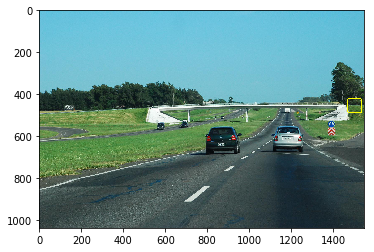

In [31]:
plt.imshow(vehiculos)

## Imagen de test

In [32]:
img_test = mpimg.imread('test0.jpg')

img_test.shape

(1037, 1549, 3)


## Extractor de Características: HOP (Histogram Oriented Phase)

In [33]:
from phasepack import phasecong

/Users/alejandrodebus/anaconda2/envs/cv/lib/python2.7/site-packages/phasepack/tools.py:14: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  'fftpack' module for 2D Fourier transforms.""")


In [36]:
img_gray = cv2.cvtColor(img_vehiculo, cv2.COLOR_BGR2GRAY)

In [37]:
plt.imshow(img, cmap='gray')

NameError: name 'img' is not defined

In [132]:
M_mod = np.zeros([64,64], dtype=float)
step = 64
for i in range(0,64,step):
    for j in range(0,64,step):
        M_mod[i:i+step, j:j+step], _, _, _, _, _, _ = phasecong(img_gray[i:i+step,j:j+step], nscale=2, norient=8, minWaveLength=6, mult=2.1,
              sigmaOnf=0.55, k=2., cutOff=0.5, g=10., noiseMethod=-1)

In [133]:
M, m, img_ori, ft, PC, Eo, T = phasecong(img_gray, nscale=2, norient=8, minWaveLength=6, mult=2.1,
              sigmaOnf=0.55, k=2., cutOff=0.5, g=10., noiseMethod=-1)

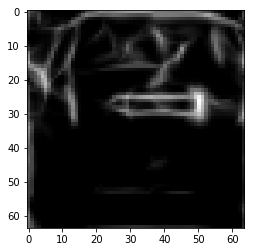

In [134]:
plt.imshow(M_mod, cmap='gray')

In [33]:
def hop(img, pixels_per_cell, cells_per_block):
    # -- Parametros de Entrada --
    # img: imagen
    #
    # -- Parametros de Salida --
    # hop: histograma de fase orientada

IndentationError: expected an indented block (<ipython-input-33-290d75181478>, line 6)

## CNN (Convolutional Neural Network)

In [37]:
from imutils import paths
from sklearn.model_selection import train_test_split

In [39]:


datos = []
etiquetas = []

for imgPath in vehiculos_n_archivos:
    datos.append(imgPath)


In [40]:
datos

['dataset/vehicles/GTI_MiddleClose/image0110.png',
 'dataset/vehicles/GTI_MiddleClose/image0104.png',
 'dataset/vehicles/GTI_MiddleClose/image0138.png',
 'dataset/vehicles/GTI_MiddleClose/image0474.png',
 'dataset/vehicles/GTI_MiddleClose/image0312.png',
 'dataset/vehicles/GTI_MiddleClose/image0306.png',
 'dataset/vehicles/GTI_MiddleClose/image0460.png',
 'dataset/vehicles/GTI_MiddleClose/image0448.png',
 'dataset/vehicles/GTI_MiddleClose/image0272.png',
 'dataset/vehicles/GTI_MiddleClose/image0299.png',
 'dataset/vehicles/GTI_MiddleClose/image0070.png',
 'dataset/vehicles/GTI_MiddleClose/image0071.png',
 'dataset/vehicles/GTI_MiddleClose/image0298.png',
 'dataset/vehicles/GTI_MiddleClose/image0273.png',
 'dataset/vehicles/GTI_MiddleClose/image0267.png',
 'dataset/vehicles/GTI_MiddleClose/image0449.png',
 'dataset/vehicles/GTI_MiddleClose/image0307.png',
 'dataset/vehicles/GTI_MiddleClose/image0461.png',
 'dataset/vehicles/GTI_MiddleClose/image0475.png',
 'dataset/vehicles/GTI_MiddleCl

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [14]:
img_vehiculo.shape

(64, 64, 3)

In [ ]:
def modelo():
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))